In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
os.chdir('..')

In [5]:
import optuna
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing, metrics
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgb
import random

from sales_forecasting.utils import timeseries_split
from sales_forecasting.plot import plot_timeseries, plot_feature_importance
from sales_forecasting.features import col_name

In [7]:
random.seed(42)
np.random.seed(42)

In [8]:
df = pd.read_parquet(".data/df_agg_monthly_oversampled.parquet")
train_split, valid_split = timeseries_split(df, max_month=33, col='date_block_num', continuous=False)
train_test_split, test_split = timeseries_split(df, max_month=34, col='date_block_num', continuous=False)
target_col = 'item_cnt_month'
train_target, valid_target = train_split[target_col].clip(0, 20), valid_split[target_col].clip(0, 20)
cols_to_drop = [target_col, 'date_block_num', 'shop_id', 'item_id']
X_train, X_valid = train_split.drop(columns=cols_to_drop), valid_split.drop(columns=cols_to_drop)

In [9]:
def objective(trial):
    param = {
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', -1, 50),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 50),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100),
        'random_state': 42,
        'verbose': -1
    }

    model = lgb.LGBMRegressor(**param, boosting_type='gbdt', n_jobs=-1, metric='rmse', objective='regression')
    model.fit(X_train, train_target, eval_set=[(X_valid, valid_target)])

    y_valid_pred = model.predict(X_valid)
    rmse = metrics.root_mean_squared_error(valid_target, y_valid_pred)
    return rmse

# Create a study and optimize the hyperparameters
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Best parameters and score
print("Best Parameters:", study.best_params)
print("Best Score:", study.best_value)

[I 2024-11-21 23:22:44,532] A new study created in memory with name: no-name-d8799061-9915-44fd-9c3b-8ae97cd9874c
[I 2024-11-21 23:22:57,305] Trial 0 finished with value: 0.46749577838006745 and parameters: {'num_leaves': 98, 'max_depth': 43, 'learning_rate': 0.7324428214459164, 'n_estimators': 50, 'reg_alpha': 5.528440832020187, 'reg_lambda': 4.286770600811872, 'colsample_bytree': 0.4, 'subsample': 1.0, 'min_child_samples': 88, 'min_data_per_groups': 60}. Best is trial 0 with value: 0.46749577838006745.
[I 2024-11-21 23:23:10,559] Trial 1 finished with value: 0.4405276158087254 and parameters: {'num_leaves': 101, 'max_depth': 13, 'learning_rate': 0.5325137324407562, 'n_estimators': 50, 'reg_alpha': 1.2496851429894829, 'reg_lambda': 2.6209255224207304, 'colsample_bytree': 0.4, 'subsample': 0.5, 'min_child_samples': 1, 'min_data_per_groups': 70}. Best is trial 1 with value: 0.4405276158087254.
[I 2024-11-21 23:23:20,143] Trial 2 finished with value: 0.4196596705911751 and parameters: {'

Best Parameters: {'num_leaves': 28, 'max_depth': 43, 'learning_rate': 0.07188714405942678, 'n_estimators': 50, 'reg_alpha': 1.862771282197631, 'reg_lambda': 0.6080693179624701, 'colsample_bytree': 1.0, 'subsample': 0.7, 'min_child_samples': 236, 'min_data_per_groups': 89}
Best Score: 0.379214483651043


In [12]:
study.trials_dataframe().sort_values(by='value').head(10)

,number,value,datetime_start,datetime_complete,duration,params_colsample_bytree,params_learning_rate,params_max_depth,params_min_child_samples,params_min_data_per_groups,params_n_estimators,params_num_leaves,params_reg_alpha,params_reg_lambda,params_subsample,state
82,82,0.379214,2024-11-21 23:36:27.626449,2024-11-21 23:36:35.646984,0 days 00:00:08.020535,1.0,0.071887,43,236,89,50,28,1.862771,0.608069,0.7,COMPLETE
88,88,0.379822,2024-11-21 23:37:19.158186,2024-11-21 23:37:27.458755,0 days 00:00:08.300569,1.0,0.071910,38,246,96,50,27,1.911943,0.497101,0.6,COMPLETE
96,96,0.380773,2024-11-21 23:38:31.640352,2024-11-21 23:38:40.298014,0 days 00:00:08.657662,1.0,0.072626,40,273,81,50,36,1.358588,0.766267,0.7,COMPLETE
81,81,0.382231,2024-11-21 23:36:19.382441,2024-11-21 23:36:27.625867,0 days 00:00:08.243426,1.0,0.031760,44,233,89,50,28,1.411007,0.607519,0.7,COMPLETE
76,76,0.382238,2024-11-21 23:35:35.230263,2024-11-21 23:35:42.999737,0 days 00:00:07.769474,1.0,0.041123,39,191,92,50,26,1.372362,0.453306,0.7,COMPLETE
77,77,0.382307,2024-11-21 23:35:43.000317,2024-11-21 23:35:51.220551,0 days 00:00:08.220234,1.0,0.029882,40,229,96,50,27,1.301235,0.099503,0.7,COMPLETE
78,78,0.382552,2024-11-21 23:35:51.221299,2024-11-21 23:35:59.272288,0 days 00:00:08.050989,1.0,0.029480,40,234,96,50,26,1.665589,0.167029,0.7,COMPLETE
75,75,0.382797,2024-11-21 23:35:27.195191,2024-11-21 23:35:35.229696,0 days 00:00:08.034505,1.0,0.035303,33,191,95,50,24,1.383824,0.678015,0.7,COMPLETE
74,74,0.383845,2024-11-21 23:35:19.513110,2024-11-21 23:35:27.194609,0 days 00:00:07.681499,1.0,0.068822,32,192,93,50,24,1.176746,1.120969,0.7,COMPLETE
71,71,0.384599,2024-11-21 23:34:55.833110,2024-11-21 23:35:03.776289,0 days 00:00:07.943179,1.0,0.048679,32,180,99,50,24,0.644087,0.808496,0.7,COMPLETE


In [13]:
study.best_params

{'num_leaves': 28,
 'max_depth': 43,
 'learning_rate': 0.07188714405942678,
 'n_estimators': 50,
 'reg_alpha': 1.862771282197631,
 'reg_lambda': 0.6080693179624701,
 'colsample_bytree': 1.0,
 'subsample': 0.7,
 'min_child_samples': 236,
 'min_data_per_groups': 89}

In [21]:
from optuna.visualization.matplotlib import plot_contour
from optuna.visualization.matplotlib import plot_edf
from optuna.visualization.matplotlib import plot_intermediate_values
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.visualization.matplotlib import plot_parallel_coordinate
from optuna.visualization.matplotlib import plot_param_importances
from optuna.visualization.matplotlib import plot_rank
from optuna.visualization.matplotlib import plot_slice
from optuna.visualization.matplotlib import plot_timeline

/var/folders/nn/v5bcwy852z121w7pz8m7sypr0000gn/T/ipykernel_68576/3794670417.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study)


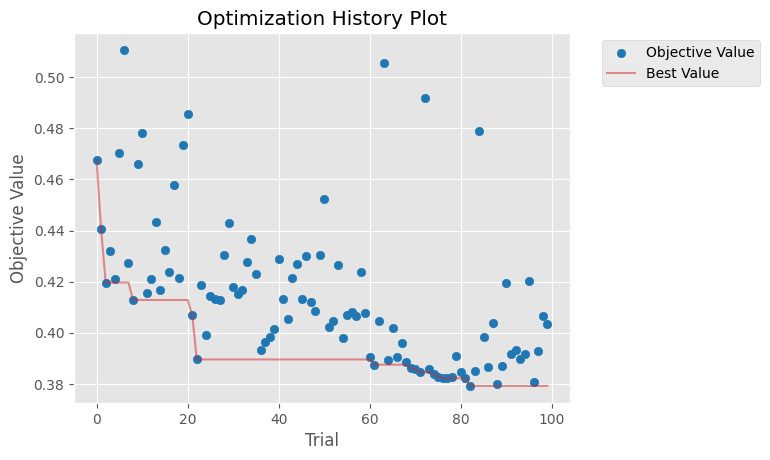

In [23]:
plot_optimization_history(study)
plt.savefig("assets/plots/hyperparameter_history.png")

/var/folders/nn/v5bcwy852z121w7pz8m7sypr0000gn/T/ipykernel_68576/3506676389.py:1: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  plot_parallel_coordinate(study, params=['learning_rate', 'num_leaves', 'max_depth'])


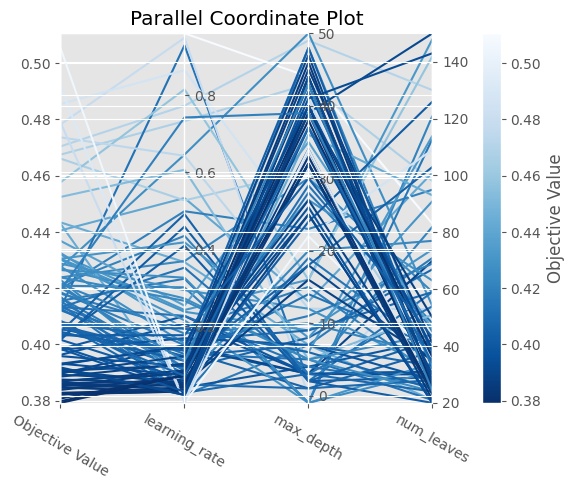

In [32]:
plot_parallel_coordinate(study, params=['learning_rate', 'num_leaves', 'max_depth'])
plt.savefig("assets/plots/parallel_coordinate_plot.png")

/var/folders/nn/v5bcwy852z121w7pz8m7sypr0000gn/T/ipykernel_68576/290918314.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  plot_slice(study, params=['colsample_bytree', 'learning_rate', 'subsample'])


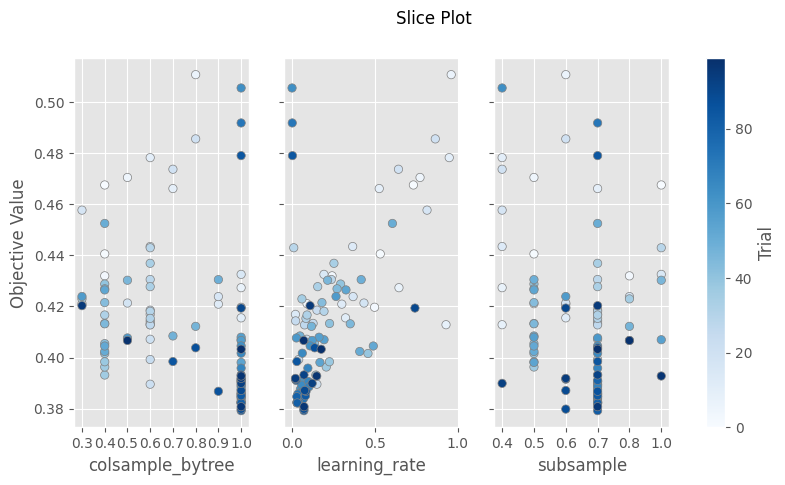

In [35]:
plot_slice(study, params=['colsample_bytree', 'learning_rate', 'subsample'])
plt.savefig("assets/plots/slice.png")

/var/folders/nn/v5bcwy852z121w7pz8m7sypr0000gn/T/ipykernel_68576/2459406562.py:1: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  plot_contour(
[W 2024-11-21 23:59:04,473] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


array([[<Axes: ylabel='max_depth'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='num_leaves'>, <Axes: >, <Axes: >],
       [<Axes: xlabel='max_depth', ylabel='reg_alpha'>,
        <Axes: xlabel='num_leaves'>, <Axes: xlabel='reg_alpha'>]],
      dtype=object)

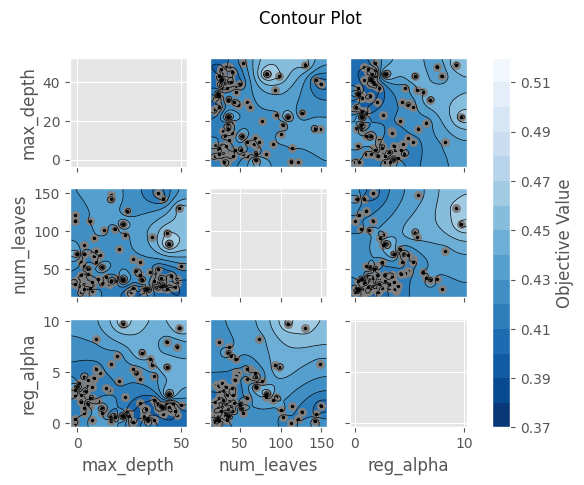

In [39]:
plot_contour(
    study, 
    params=['num_leaves','max_depth', 'reg_alpha']
)

/var/folders/nn/v5bcwy852z121w7pz8m7sypr0000gn/T/ipykernel_68576/3074613899.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study)


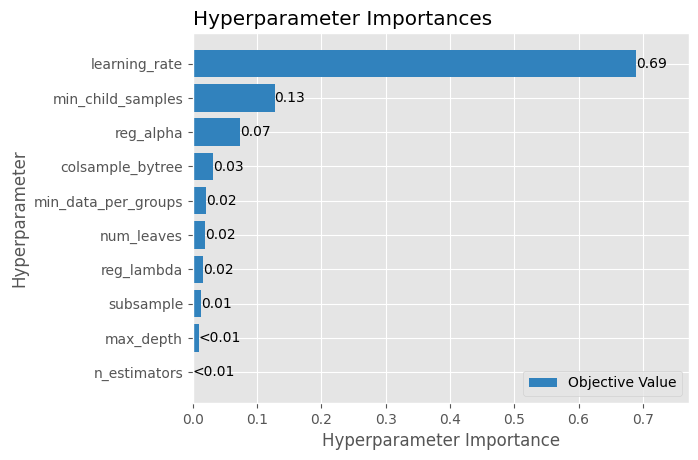

In [42]:
plot_param_importances(study)
plt.savefig("assets/plots/imp_hyperparam.png")